# Praxis

In [32]:
import time
import random
import numpy as np
import pandas as pd
import ringity as rng
import networkx as nx
import scipy.stats as ss
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

from scipy.integrate import quad
from scipy.spatial.distance import pdist, squareform
from ringity.classes.network_model import NetworkBuilder

## Distribution

In [2]:
N = 2**12
beta = 0.523

rate  = np.tan(np.pi * (1-beta) / 2)
delay = 1 - 2/np.pi * np.arctan(rate)

network_builder = NetworkBuilder(random_state = 1234)
network_builder.set_distribution('exponential', scale = 1/rate)
network_builder.instantiate_positions(N)

In [3]:
assert np.isclose(delay, beta)

Given a wrapped exponential distribution with rate parameter $\lambda$, i.e. $\Theta\sim \mathit{WrapExp}(\lambda)$ the pdf can be expressed as
$$f_{\Theta}(t) = \frac{\lambda e^{-\lambda t}}{1-e^{-2\pi\lambda}} \; .$$

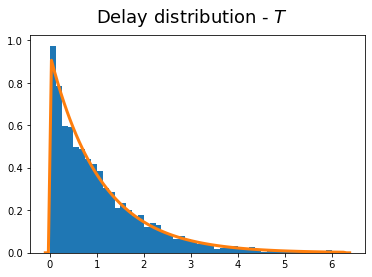

In [4]:
x = np.linspace(-0.1,2*np.pi+0.1,100)

plt.hist(network_builder.positions, density=True, bins=50);
plt.plot(x, rng.pdf_delay(x, rate, 'rate') , linewidth=3)

plt.suptitle("Delay distribution - $T$", fontsize=18);

In [5]:
mu1 = np.mean(network_builder._positions)
mu2 = quad(lambda x : x*rng.pdf_delay(x, rate, 'rate'), 0, 2*np.pi)[0]

print(mu1)
print(mu2)

1.0586428952145024
1.056757304047466


In [6]:
rv = ss.truncexpon(b = 2*np.pi*rate, scale = 1/rate)
rv.mean()

1.0567573040474658

In [7]:
ss.ks_1samp(network_builder._positions, rv.cdf)

KstestResult(statistic=0.017713199345091052, pvalue=0.15115724629722116)

## Distances and Similarity

In [323]:
N = 2**12
beta = np.random.uniform(0,1)
alpha = np.random.uniform(0, 0.5)

rate  = np.tan(np.pi * (1-beta) / 2)
delay = 2/np.pi * np.arctan(rate)

network_builder = NetworkBuilder(random_state = 1234)
network_builder.set_distribution('exponential', scale = 1/rate)
network_builder.instantiate_positions(N)
network_builder.calculate_distances(metric = 'euclidean', circular = True)
network_builder.calculate_similarities(alpha = alpha, sim_func = 'box_cosine')

The circular distance is defined as $D = \min {\left\{ |X-Y|, 2\pi-|X-Y|\right\}}$. The corresponding pdf can be calculated via $f_{D}(t) = f_{|X-Y|}(t) + f_{|X-Y|}(2\pi-t)$ where $f_{|X-Y|}(t) = 2 \cdot f_{\Theta}(t) * f_{\Theta}(-t)$. This boils down to

$$f_{D}(t) = \frac {\lambda}{\sinh(\pi\lambda)}\cdot \cosh(\lambda \cdot (\pi-t)) \; .$$

The corresponding conditional density distribution is defined as $D_{\vartheta} = \min {\left\{ |X-\vartheta|, 2\pi-|X-\vartheta| \right\}}$ and can be calculated via $f_{D_{\vartheta}}(t) = f_{|X-\vartheta|}(t) + f_{|X-\vartheta|}(2\pi-t)$ where $f_{|X-\vartheta|}(t) = f_{\Theta}(\vartheta+t) + f_{\Theta}(\vartheta-t)$. This boils down to 

$$f_{D_{\vartheta}}(t) = \frac{2\lambda e^{-\lambda \vartheta}}{1 - e^{-2\pi\lambda}} \cdot
\begin{cases}
\cosh(\lambda t) & \text{, for } t \leq \min \{ \vartheta, 2\pi - \vartheta \} \\
\cosh(\lambda (\pi-t)) \cdot e^{\operatorname{sgn} (\vartheta - t) \lambda \pi}  & \text{, for } t \geq \min \{ \vartheta, 2\pi - \vartheta \} \; .
\end{cases}
$$

The expected conditional density distribution, is given by

$$\mathbb{E}[D_{\vartheta}] = 
\begin{cases}
\frac{1}{\lambda}
    \left( \frac{2e^{-\lambda\vartheta}}{1 + e^{-\pi\lambda}} - 1 \right) 
&+ \, \vartheta
& \text{, for } \vartheta \leq \pi \\
\frac{1}{\lambda} 
    \left(1 - \frac{2e^{\lambda(2\pi-\theta)}}{1 + e^{\pi\lambda}} \right)
&+ \, (2\pi - \vartheta)
& \text{, for } \vartheta \geq \pi \; .
\end{cases}
$$

Should this be rewritten as $\theta = \pi + \delta$?

In [9]:
def pdf_conditional_circular_distance(t, theta, rate):
    support = np.where((0 <= t) & (t <= np.pi), 1, 0.)
    norm = 2*rate*np.exp(-rate*theta) / (1 - np.exp(-2*np.pi*rate))
    
    cond = (t <= min(theta, 2*np.pi-theta))
    
    term = np.where(cond, 
                    np.cosh(rate*t), 
                    np.cosh(rate*(np.pi-t)) * np.exp(np.sign(theta-t)*rate * np.pi))
    
    return support * norm * term

def expected_conditional_circular_distance(theta, rate):
    if theta < np.pi:
        term = 2*np.exp(-rate*theta) / (1 + np.exp(-np.pi*rate))
        return theta + (term - 1) / rate
        
    else:
        term = 2*np.exp(rate*(2*np.pi-theta)) / (1 + np.exp(np.pi*rate))
        return (2*np.pi-theta) + (1-term) / rate

In [10]:
thetas = np.linspace(0, 2*np.pi, 100)
dists1 = [quad(lambda t : t*pdf_conditional_circular_distance(t, theta=theta, rate=rate), 0, np.pi)[0]
                    for theta in thetas]
dists2 = [expected_conditional_circular_distance(theta=theta, rate=rate)
                    for theta in thetas]

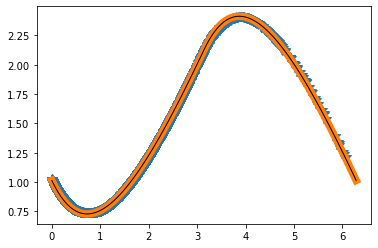

In [11]:
plt.plot(network_builder.positions,
         network_builder.distances.mean(axis=0), '*', markersize=10)
plt.plot(thetas, dists1, linewidth=7.5)
plt.plot(thetas, dists2, 'k', linewidth=1)

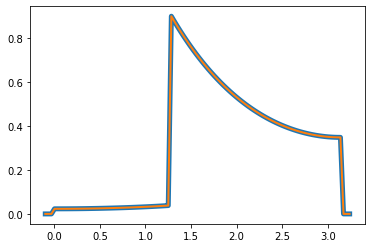

In [12]:
x = np.linspace(-0.1, np.pi+0.1, 100)
theta = 5

fig, ax = plt.subplots()

ax.plot(x, rng.pdf_conditional_circular_distance(x, theta=theta, parameter=rate, parameter_type='rate'), 
        linewidth=5)
ax.plot(x, pdf_conditional_circular_distance(x, theta, rate) , linewidth=2)

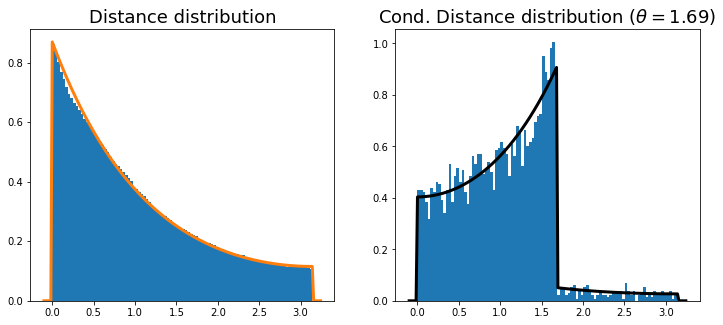

In [13]:
x = np.linspace(-0.1, np.pi+0.1, 200)

i = 100
theta = network_builder._positions[i]

fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.hist(network_builder._distances, density=True, bins=100);
ax1.plot(x, rng.pdf_circular_distance(x, rate, 'rate') , linewidth=3)
ax1.set_title("Distance distribution", fontsize=18);

ax2.hist(network_builder.distances[i,:], density=True, bins=100);
ax2.plot(x, pdf_conditional_circular_distance(x, theta=theta, rate=rate) , linewidth=3, c='k')
ax2.set_title(rf"Cond. Distance distribution ($\theta = {theta:.2f}$)", fontsize=18);

In [14]:
%%timeit 

rng.pdf_conditional_circular_distance(x, theta=theta, parameter=rate, parameter_type='rate')

163 µs ± 9.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [15]:
%%timeit

pdf_conditional_circular_distance(x, theta, rate)

44 µs ± 405 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


---

**For $a \leq 0.5$ (!)**, the similarity is defined as $S = \left| 1 - \frac{D}{2\pi a} \right|_{+}$. The corresponding pdf can be calculated via $f_{S}(t) = 2a\pi \cdot f_D \big(2a\pi(1-t) \big)$. This boils down to

$$f_{S}(t) = 
\begin{cases}
s_0 \delta_0 & \text{, for } t = 0 \\
\frac {2\pi a \lambda}{\sinh(\pi\lambda)} \cdot \cosh \Big(\lambda \pi \big(1-(2a-t)\big) \Big)& \text{, for } t \geq 0 \\
\end{cases}
 \; .$$

The corresponding conditional density distribution is defined as $S_{\vartheta} = \left| 1 - \frac{D_{\vartheta}}{2\pi a} \right|_{+}$ and can be calculated via $f_{S_{\vartheta}}(t) = 2a\pi \cdot f_{D_{\vartheta}} \big(2a\pi(1-t) \big)$. This boils down to 

$$f_{S_{\vartheta}}(t) = \frac{2a\pi2\lambda e^{-\lambda \vartheta}}{1 - e^{-2\pi\lambda}} \cdot
\begin{cases}
\cosh(\lambda t) & \text{, for } t \geq 1-\frac{\min \{ \vartheta, 2\pi - \vartheta \}}{2a\pi} \\
\cosh(\lambda (\pi-t)) \cdot e^{\operatorname{sgn} (\vartheta - t) \lambda \pi}  & \text{, for } t \leq 1-\frac{\min \{\vartheta, 2\pi - \vartheta \}}{2a\pi} \; .
\end{cases}
$$

In [16]:
def pdf_conditional_similarity(t, theta, a, rate):
    support = np.where((0 <= t) & (t <= 1), 1, 0.)
    norm = 4*a*np.pi*rate*np.exp(-rate*theta) / (1 - np.exp(-2*np.pi*rate))
    
    cond = (t >= 1 - min(theta, 2*np.pi-theta) / (2*a*np.pi))
    
    term = np.where(cond, 
                    np.cosh(rate*2*a*np.pi*(1-t)),
                    np.cosh(rate*np.pi*(1-2*a*(1-t))) * np.exp(np.sign(theta-2*a*np.pi*(1-t))*rate * np.pi))
    
    return support * norm * term

def expected_conditional_similarity(theta, rate, a):
    if theta < np.pi:
        if theta <= 2*np.pi*a:
            norm = 1 / (1 - np.exp(-2*np.pi*rate)) / (2*a*np.pi*rate)
            term =  np.exp(-rate*theta)*(np.exp(-2*a*np.pi*rate) + np.exp((2*a*np.pi - 2*np.pi)*rate) - 2)
            
            return norm*term + 1 + (1 - theta*rate)/(2*a*np.pi*rate)
        else:
            theta_term = np.exp(-rate*theta) / (1 - np.exp(-2*np.pi*rate))
            alpha_term = (np.cosh(-rate*2*np.pi*a) - 1) / (a*np.pi*rate)
            return theta_term * alpha_term
        
    else:
        norm = 1 / (1 - np.exp(-2*np.pi*rate)) / (2*a*np.pi*rate)
        
        if 2*np.pi - theta <= 2*np.pi*a:
            term = np.exp(-theta*rate)*(np.exp(2*np.pi*rate)*(np.exp((-2*np.pi*a)*rate) + np.exp(2*np.pi*a*rate) - 2)
            
            theta_term = -rate*(2*np.pi - theta) / (2*a*np.pi*rate)
            
            return norm*term + 1 - (1 + rate*(2*np.pi - theta)) / (2*a*np.pi*rate)
        else:
            return 4*np.exp(-rate*theta)*norm*(np.sinh(a*np.pi*rate)**2)

In [17]:
thetas = np.linspace(0, 2*np.pi, 50)
simis1 = [quad(lambda t : t*pdf_conditional_similarity(t, theta=theta, rate=rate, a=alpha), 0, np.pi)[0]
                    for theta in thetas]
simis2 = [expected_conditional_similarity(theta=theta, rate=rate, a=alpha)
                    for theta in thetas]

/var/folders/hr/pw6v38ln34d_87nsgcx3qjz80000gn/T/ipykernel_43767/3954974193.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  simis1 = [quad(lambda t : t*pdf_conditional_similarity(t, theta=theta, rate=rate, a=alpha), 0, np.pi)[0]


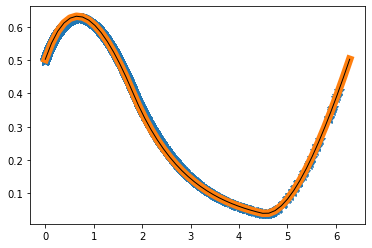

In [18]:
plt.plot(network_builder.positions,
         network_builder.similarities.mean(axis=0), '*', markersize=10)
plt.plot(thetas, simis1, linewidth=7.5)
plt.plot(thetas, simis2, 'k', linewidth=1)

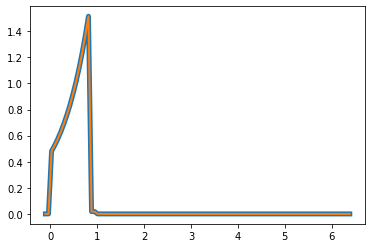

In [19]:
x = np.linspace(-0.1, 2*np.pi+0.1, 100)
theta = 6

fig, ax = plt.subplots()

ax.plot(x, rng.pdf_conditional_similarity(x, 
                                          theta=theta, 
                                          a=alpha,
                                          parameter=rate, 
                                          parameter_type='rate'), 
        linewidth=5)
ax.plot(x, pdf_conditional_similarity(x, theta=theta, a=alpha, rate=rate) , linewidth=2)

In [20]:
mu1 = np.mean(network_builder._distances)
mu2 = quad(lambda x : x*rng.pdf_circular_distance(x, rate, 'rate'), 0, 2*np.pi)[0]

print(mu1)
print(mu2)

1.0206284992064942
1.0147420862786787


In [21]:
disc_part = 2*(network_builder._similarities!=0).sum() / (N*(N-1))

(0.0, 5.0)

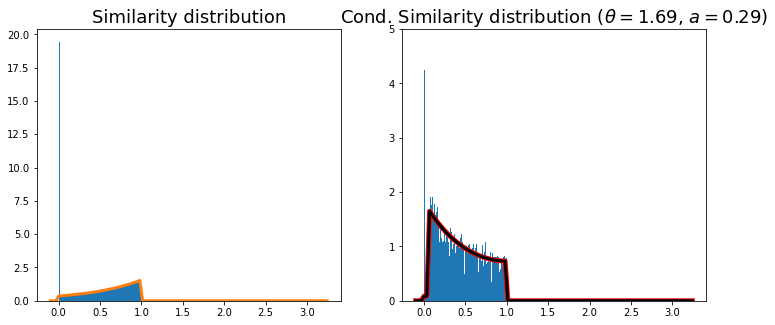

In [22]:
x = np.linspace(-0.1, np.pi+0.1, 100)

i = 100
theta = network_builder._positions[i]

fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.hist(network_builder._similarities, density=True, bins=100);
ax1.plot(x, rng.pdf_similarity(x, parameter=rate, parameter_type='rate', a=alpha) , linewidth=3)
ax1.set_title("Similarity distribution", fontsize=18);

ax2.hist(network_builder.similarities[i,:], density=True, bins=100);
ax2.plot(x, rng.pdf_conditional_similarity(x, theta=theta, parameter=rate, a=alpha) , linewidth=5, c='r')
ax2.plot(x, pdf_conditional_similarity(x, theta=theta, rate=rate, a=alpha) , linewidth=3, c='k')
ax2.set_title(rf"Cond. Similarity distribution ($\theta = {theta:.2f}$, $a = {alpha:.2f}$)", fontsize=18);

ax2.set_ylim(0, 5)

In [23]:
%%timeit 

rng.pdf_conditional_similarity(x, theta=theta, a=alpha, parameter=rate, parameter_type='rate')

175 µs ± 23.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [24]:
%%timeit

pdf_conditional_similarity(x, theta=theta, rate=rate, a=alpha)

49.7 µs ± 4.03 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [25]:
def pdf_conditional_mean_similarity(theta, a, rate):
    return 2*np.pi*a*quad(lambda t : t*pdf_conditional_similarity(t, theta=theta, rate=rate, a=alpha), 0, 1)[0]

In [26]:
x = np.linspace(-0.1, np.pi+0.1, 100)

i = 100
theta = network_builder._positions[i]
np.mean(network_builder.similarities[i,:])

0.4450027220867226

In [27]:
print(quad(lambda t : t*pdf_conditional_similarity(t, theta=theta, rate=rate, a=alpha), 0, 1)[0])
print(pdf_conditional_mean_similarity(theta=theta, a=alpha, rate=rate))

0.4419001984356344
0.799639546166145


# Expected degree

In [492]:
N = 2**10
beta = np.random.uniform()
alpha = np.random.uniform(0, 0.5)
theta = np.random.uniform(0, 1)

rate  = np.tan(np.pi * (1-beta) / 2)

max_rho = rng.classes.network_model.mean_similarity(a=alpha, rate = rate)
rho = np.random.uniform(0, max_rho)

K = rng.classes.network_model.density_to_interaction_strength(rho, a=alpha, rate=rate)
density = rng.classes.network_model.mean_similarity(a=alpha, rate = rate)*K

degrees = []

n_ensembl = 2**9
for _ in range(n_ensembl):
    network_builder = NetworkBuilder()
    network_builder.set_distribution('exponential', scale = 1/rate)
    network_builder.instantiate_positions(N)
    network_builder.positions[0] = theta
    network_builder.calculate_distances(metric = 'euclidean', circular = True)
    network_builder.calculate_similarities(alpha = alpha, sim_func = 'box_cosine')
    network_builder.calculate_probabilities(intercept=0, slope = K)
    network_builder.instantiate_network()
    
    degrees.append(squareform(network_builder.network)[0].sum())

In [493]:
RV = ss.binom(N-1, np.mean(degrees) / (N-1)) 

In [494]:
RV.cdf(5)

0.049497290170969724

In [495]:
ss.ks_1samp(degrees, RV.cdf)

KstestResult(statistic=0.12369251366851419, pvalue=2.7580361451150975e-07)

In [496]:
np.mean(degrees), RV.mean()

(10.501953125, 10.501953125)

In [497]:
np.var(degrees), RV.var()

(11.124996185302734, 10.394141766798928)

In [498]:
ss.skew(degrees), np.sqrt(RV.moment(2))

(0.3011221427308235, 10.985679824503178)

In [499]:
p = np.mean(degrees) / (N-1)
q = 1-p

(q-p) / np.sqrt((N-1)*p*q)

0.30380581119072003

In [474]:
p

94.35546875

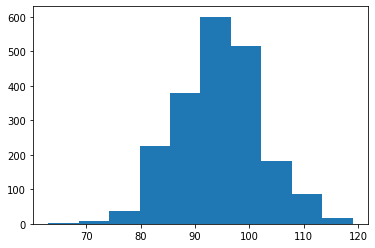

In [449]:
plt.hist(degrees);

In [446]:
np.mean(degrees), np.var(degrees) / n_ensembl

(94.35546875, 0.029270462691783905)

In [447]:
(N-1)*expected_conditional_similarity(theta=theta, rate=rate, a=alpha)*K

94.02008612928158

## Probability

In [28]:
N = 2**10
beta = np.random.uniform()
alpha = np.random.uniform(0, 0.5)

rate  = np.tan(np.pi * (1-beta) / 2)

max_rho = rng.classes.network_model.mean_similarity(a=alpha, rate = rate)
rho = np.random.uniform(0, max_rho)

K = rng.classes.network_model.density_to_interaction_strength(rho, a=alpha, rate=rate)
density = rng.classes.network_model.mean_similarity(a=alpha, rate = rate)*K

network_builder = NetworkBuilder()
network_builder.set_distribution('exponential', scale = 1/rate)
network_builder.instantiate_positions(N)
network_builder.calculate_distances(metric = 'euclidean', circular = True)
network_builder.calculate_similarities(alpha = alpha, sim_func = 'box_cosine')
network_builder.calculate_probabilities(intercept=0, slope = K)
network_builder.instantiate_network()

In [29]:
assert np.isclose(rho, density)

In [30]:
def pdf_conditional_probability(t, theta, a, rate, K):
    support = np.where((0 <= t) & (t <= 1), 1, 0.)
    
    norm = 4*a*np.pi*rate*np.exp(-rate*theta) / (1 - np.exp(-2*np.pi*rate))
    cond = (t >= 1 - min(theta, 2*np.pi-theta) / (2*a*np.pi))
    
    term = np.where(cond, 
                    np.cosh(rate*2*a*np.pi*(1-t)),
                    np.cosh(rate*np.pi*(1-2*a*(1-t))) * np.exp(np.sign(theta-2*a*np.pi*(1-t))*rate * np.pi))
    
    return support * norm * term / K

In [33]:
x = np.linspace(-0.1, np.pi+0.1, 100)

for i in random.sample(range(100), 10):
    theta = network_builder._positions[i]

    print(np.mean(network_builder.probabilities[i,:]))
    print(quad(lambda t : t/K * pdf_conditional_similarity(t/K, theta=theta, rate=rate, a=alpha), 0, 1)[0])
    print(pdf_conditional_mean_probability(theta=theta, a=alpha, rate=rate, K=K))
    
    print()

0.022620628911794286
0.02265946177501107
0.022661239161688943

0.019542889977154282
0.019597466775240168
0.01959746881734731

0.021810151470220925
0.02181965523694154
0.02182019052377433

0.020488158648946306
0.020529646254054935
0.020529679677497525

0.02243812527368196
0.022513259199700833
0.02251325939761954

0.02010670592413447
0.020225186264653753
0.02022518600270771

0.01007490316661099
0.010066098102100605


NameError: free variable 'integrand' referenced before assignment in enclosing scope